In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Define system matrices for the reference model
Am = np.array([[ 0,    1],
               [-24, -10]])

Bm = np.array([0, 24])

# Lyapunov matrix for adaptive control
P = 1/96*np.array([[140, 2], 
                   [ 2,  5]])

# Adaptive gains
Γx = np.array([[1, 0],
               [0, 2]])
Γr = 1
Γθ = 10

# System parameters
N = 50  # number of rotor slots
J, Km, b = 4.5*np.float_power(10,-5), 0.19, 8*np.float_power(10,-4)  # Moment of Inertia, Motor Torque Constant, Friction Coefficient
A = np.array([[0,   1 ],
              [0, -b/J]])

B = np.array([0, 1])

In [3]:
np.random.seed(6)
# Function to add uncertainty to system parameters
def uncertainty(x, u, limit=0):
    if (limit!=0): return (1+np.sign(limit)*u)*x
    else:          return np.random.uniform((1-u)*x,(1+u)*x)

In [4]:
# Introduce 5% uncertainty in the physical parameters
p = 0.05
J_est, Km_est, b_est = uncertainty(J,p), uncertainty(Km,p), uncertainty(b,p)

# Calculate ideal and initial adaptive control gains
I = 1 
Λ = Km / J * I  # System parameter for the ideal model
λ = Km_est / J_est * I  # System parameter for the estimated model
print(λ / Λ)  # Print the ratio of estimated to ideal parameters

# Ideal and initial control gains
Kx_ideal = 1 / Λ * np.array([-24, -10 + b / J])
Kx0 = 1 / λ * np.array([-24, -10 + b_est / J_est])
Kr_ideal = np.float64(24 / Λ)
Kr0 = 24 / λ

0.9460321472662822


In [5]:
# Function to model an external, unknown torque disturbance
def external_torque(x):
    return 1e-3 * np.float_power(np.cos(2 * x), 2) * np.sin(3 * x)

In [6]:
# Function to simulate the system with adaptive control
def real_vs_adaptive_system(t, Z, degrees, Dt=1, 
                            ext_torque=False, nn_torque_model=None, continuous=False):
    # Unpack state variables
    x = Z[0:2]  # Actual system state
    xm = Z[2:4]  # Reference model state
    Kx = np.array([Z[4], Z[5]])  # Adaptive gains for state feedback
    Kr = Z[6]  # Adaptive gain for reference input
    Θ = Z[7]  # Adaptive gain for external torque compensation

    # Reference input calculation
    ref = np.floor(t / Dt)
    if continuous:
        ref = t / Dt
    r = np.pi * degrees / 180 * ref  # Reference signal (in radians)

    # External torque and neural network torque model
    TL, Φ = 0, 0
    if ext_torque:
        TL = external_torque(x[0])  # External unknown torque
        if nn_torque_model is not None:  # Use neural network to estimate torque
            x_torch = torch.from_numpy(np.reshape(x[0], (1, 1)))
            Φ = np.squeeze(nn_torque_model(x_torch).detach().numpy())

    # Compute the derivatives for the reference model and the actual system
    dXm = np.dot(Am, xm) + np.dot(Bm, r)  # Reference model dynamics
    u = np.dot(Kx.T, x) + np.dot(Kr.T, r) + np.dot(Θ.T, Φ)  # Control input
    dX = np.dot(A, x) + np.dot(np.dot(B, Λ), u)  # System dynamics
    dX[1] -= TL / J  # Add external torque effect

    # Adaptive control law
    e = x - xm  # Tracking error
    M = -np.dot(np.dot(e.T, P), B)  # Adaptation signal
    dKx = np.dot(np.dot(Γx, x), M)  # Update law for Kx
    dKr = np.dot(np.dot(Γr, r), M)  # Update law for Kr
    dΘ = np.dot(np.dot(Γθ, Φ), M)  # Update law for Θ

    # Concatenate all derivatives into a single vector
    DZ = np.concatenate((dX, dXm, dKx, [dKr, dΘ]))
    return DZ

In [7]:
# Function to run the simulation
def simulate_system(t_span, degrees=5, Dt=3, 
                    ext_torque=False, nn_torque_model=None, continuous=False):
    return solve_ivp(fun=real_vs_adaptive_system, t_span=[0, t_span], 
                     y0=[0, 0, 0, 0, Kx0[0], Kx0[1], Kr0, 0], 
                     dense_output=True, method='RK45', 
                     args=(degrees, Dt, ext_torque, nn_torque_model, continuous))

# Function to plot the system response (angle and angular velocity)
def plot_response(solution, x1, string=""):
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(solution.t, 180 / np.pi * solution.y[x1, :], label='System')
    plt.plot(solution.t, 180 / np.pi * solution.y[x1 + 2, :], '--', label='Reference model')
    plt.legend(fontsize=13)
    ax.set_xlabel("time (sec)", fontsize=14)
    if x1 == 0:
        plt.title("Stepper motor response" + string + 
                  ":\nplot of rotation angle over time", fontsize=14)
        ax.set_ylabel("θ (°)", fontsize=14)
    elif x1 == 1:
        plt.title("Stepper motor response" + string + 
                  ":\nplot of angular velocity over time", fontsize=14)
        ax.set_ylabel("ω (rad/sec)", fontsize=14)
    plt.show()

# Function to plot the evolution of adaptive parameters
def plot_parameters(solution, nonlinear=False):
    fig, ax = plt.subplots(3 + int(nonlinear), 1, sharex=True, figsize=(15, 11))
    ideal_K = np.repeat(np.array([Kx_ideal[0], Kx_ideal[1], Kr_ideal])[:, None], 
                        np.size(solution.t), axis=1)
    for i in range(3):
        ax[i].plot(solution.t, solution.y[4 + i, :], label='Estimated')
        ax[i].plot(solution.t, ideal_K[i], '--', label='Ideal')
        ax[i].legend(fontsize=13)
    if nonlinear:
        ax[3].plot(solution.t, solution.y[7, :])
    fig.suptitle("Evolution of adaptive parameters over time", fontsize=14, y=0.91)
    ax[0].set_ylabel("Kx1", fontsize=14)
    ax[1].set_ylabel("Kx2", fontsize=14)
    ax[2].set_ylabel("Kr", fontsize=14)
    if nonlinear:
        ax[3].set_ylabel("Θ", fontsize=14)
    ax[2 + int(nonlinear)].set_xlabel("time (sec)", fontsize=14)
    plt.show()

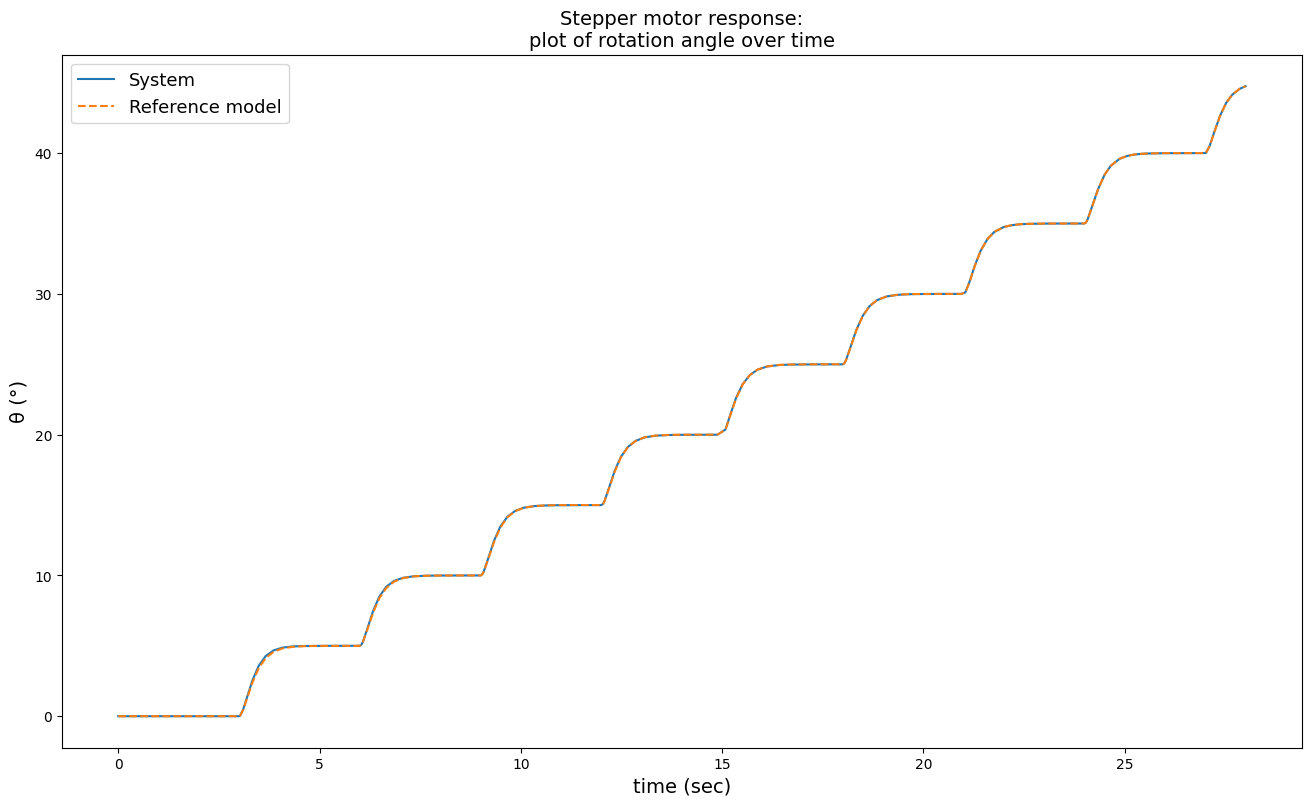

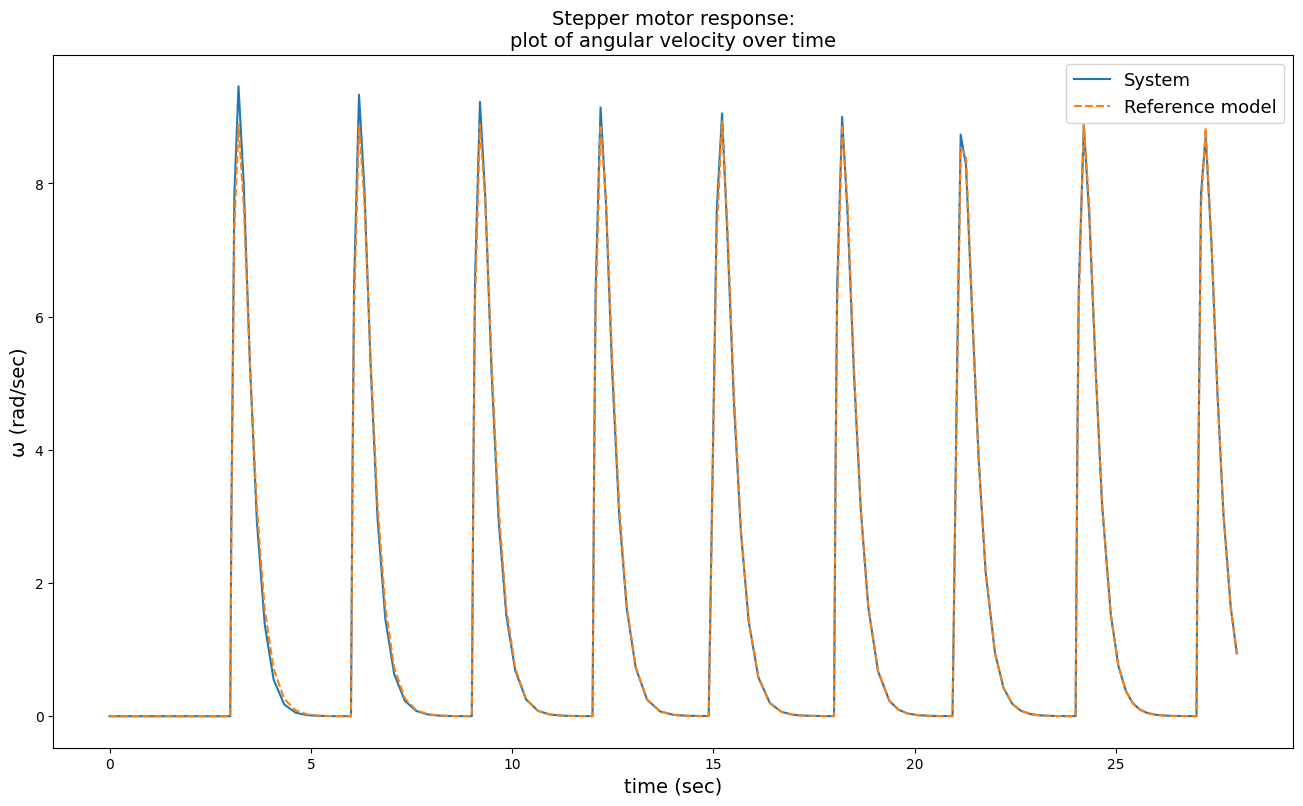

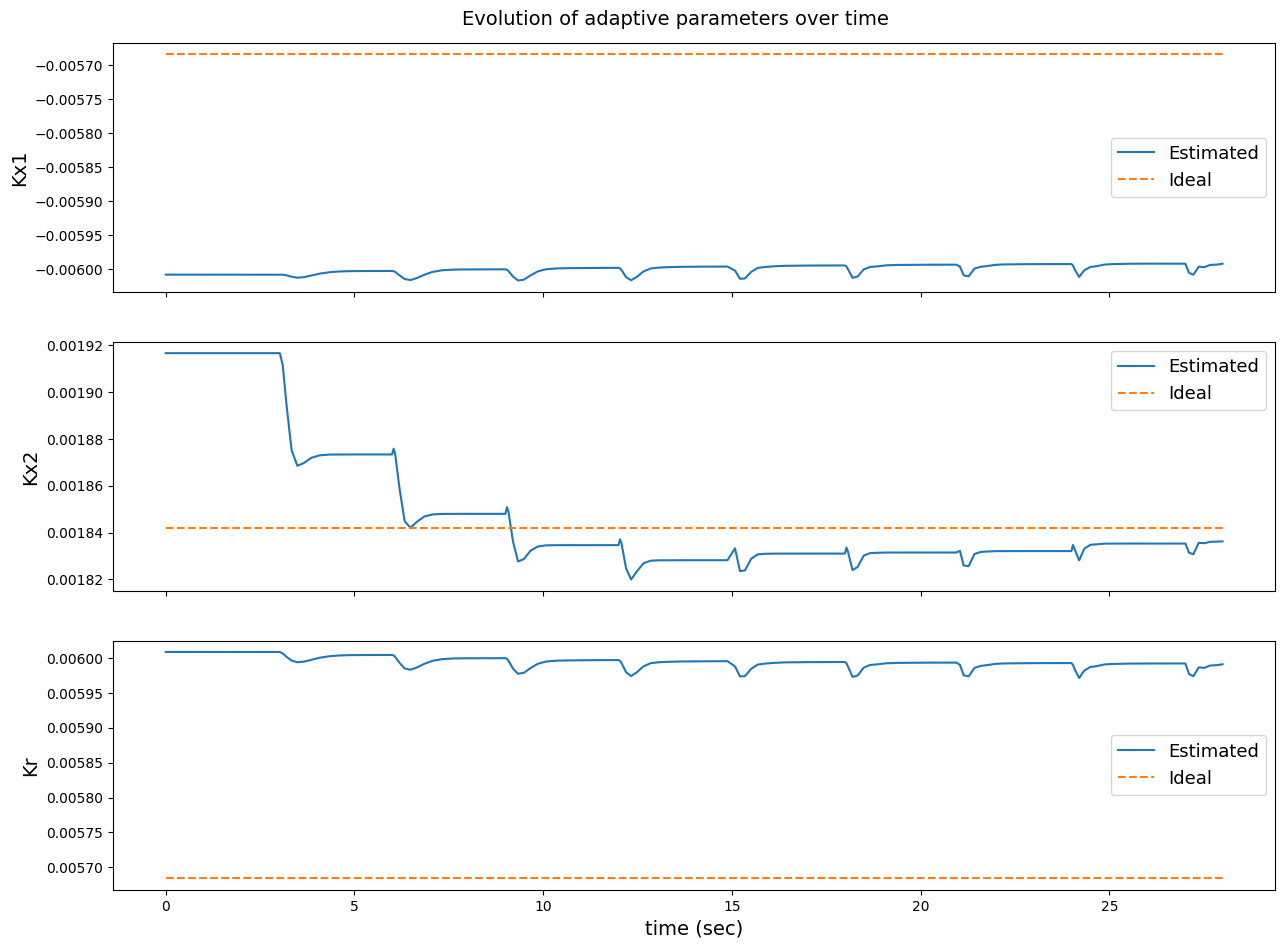

In [8]:
# Simulate and plot the system response and parameters
solution = simulate_system(t_span=28)
plot_response(solution, 0)
plot_response(solution, 1)
plot_parameters(solution)

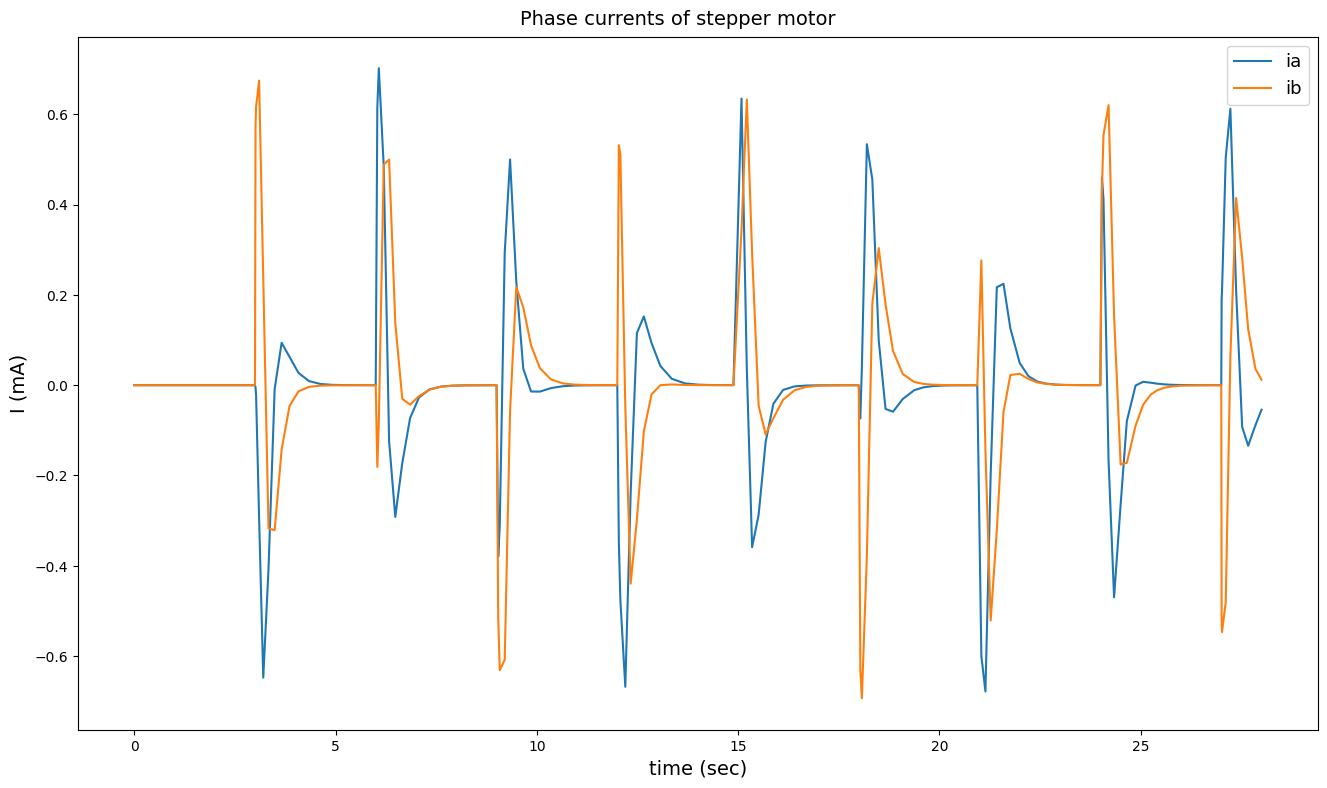

In [9]:
# Calculate and plot phase currents of the stepper motor
t = solution.t
x = solution.y
step = np.floor(t)
r = np.pi * 5 / 180 * (np.divmod(step, 3)[0])
u = x[4] * x[0] + x[5] * x[1] + x[6] * r
ia = -I * u * np.sin(50 * x[0])
ib = I * u * np.cos(50 * x[0])

fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(t, 1000 * ia, label='ia')
plt.plot(t, 1000 * ib, label='ib')
plt.legend(fontsize=13)
ax.set_xlabel("time (sec)", fontsize=14)
ax.set_ylabel("I (mA)", fontsize=14)
fig.suptitle("Phase currents of stepper motor", fontsize=14, y=0.91)
plt.show()

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [13]:
# Create training data for the neural network
step = np.pi*1e-4
n = np.arange(start=0, stop=2*np.pi, step=step)
func = 1e3*external_torque(n)

X, y = n, func
X_train, y_train = X, y
X_train, y_train = X_train[:,None], y_train[:,None]

Xy_train = torch.from_numpy(np.concatenate((X_train,y_train),axis=1))

In [14]:
# input size, input layer size, hidden layer size, output size and batch size
input_size, n_in, n_h, n_out, batch_size = 1, 10, 10, 1, int(y_train.size/20)

In [15]:
# Create a model
model = nn.Sequential(
    nn.Linear(input_size, n_in),
    nn.Tanh(),
    nn.Linear(n_in, n_h),
    nn.Tanh(),
    nn.Linear(n_h, n_out),
    nn.Tanh()).double()

In [16]:
# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Adamax in this case)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01)

In [17]:
# Gradient Descent
losses = []
epochs = 3000
epoch = 0
train_error = 0
max_error = ((n_in+2)*(n_h+2)-3)/n.size/2
print(max_error)
while (epoch<epochs or train_error>max_error):
    running_average_loss = 0
    train_data = DataLoader(Xy_train, batch_size=batch_size, shuffle=True, num_workers=0)
    for i, data in enumerate(train_data): # loop through batches
        X_batch, y_batch = data[:,0], data[:,1]
        X_batch, y_batch = X_batch[:,None], y_batch[:,None]

        # Zero gradients
        optimizer.zero_grad()
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(X_batch)
        # Compute and print loss
        loss = criterion(y_pred, y_batch)
        # perform a backward pass (backpropagation)
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        running_average_loss += loss.detach().item()
    losses.append(running_average_loss/(i+1))
    if epoch % (epochs/10) == (epochs/10-1):
        print('epoch: ', epoch,' loss: ', losses[epoch])
    train_error = losses[epoch]
    epoch += 1

0.003525
epoch:  299  loss:  0.030648938430481422
epoch:  599  loss:  0.027302507367034396
epoch:  899  loss:  0.0173580308439963
epoch:  1199  loss:  0.005739890832562168
epoch:  1499  loss:  0.004920162117678686
epoch:  1799  loss:  0.004088192607420617
epoch:  2099  loss:  0.003861347871754261
epoch:  2399  loss:  0.003724041404509367
epoch:  2699  loss:  0.0036157380826856793
epoch:  2999  loss:  0.0035181213696617412


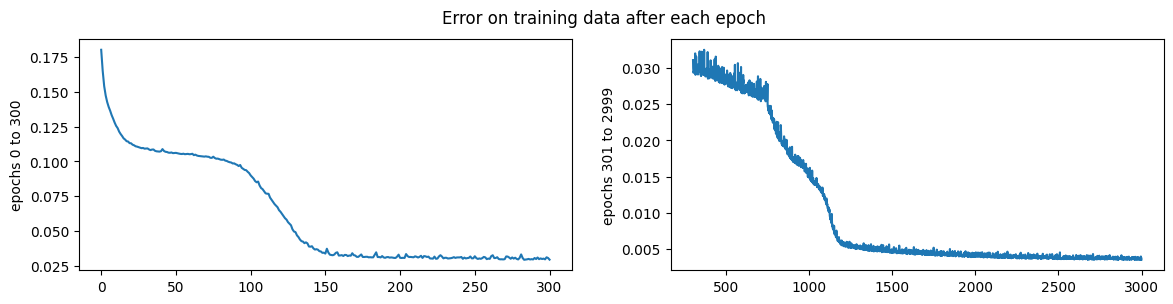

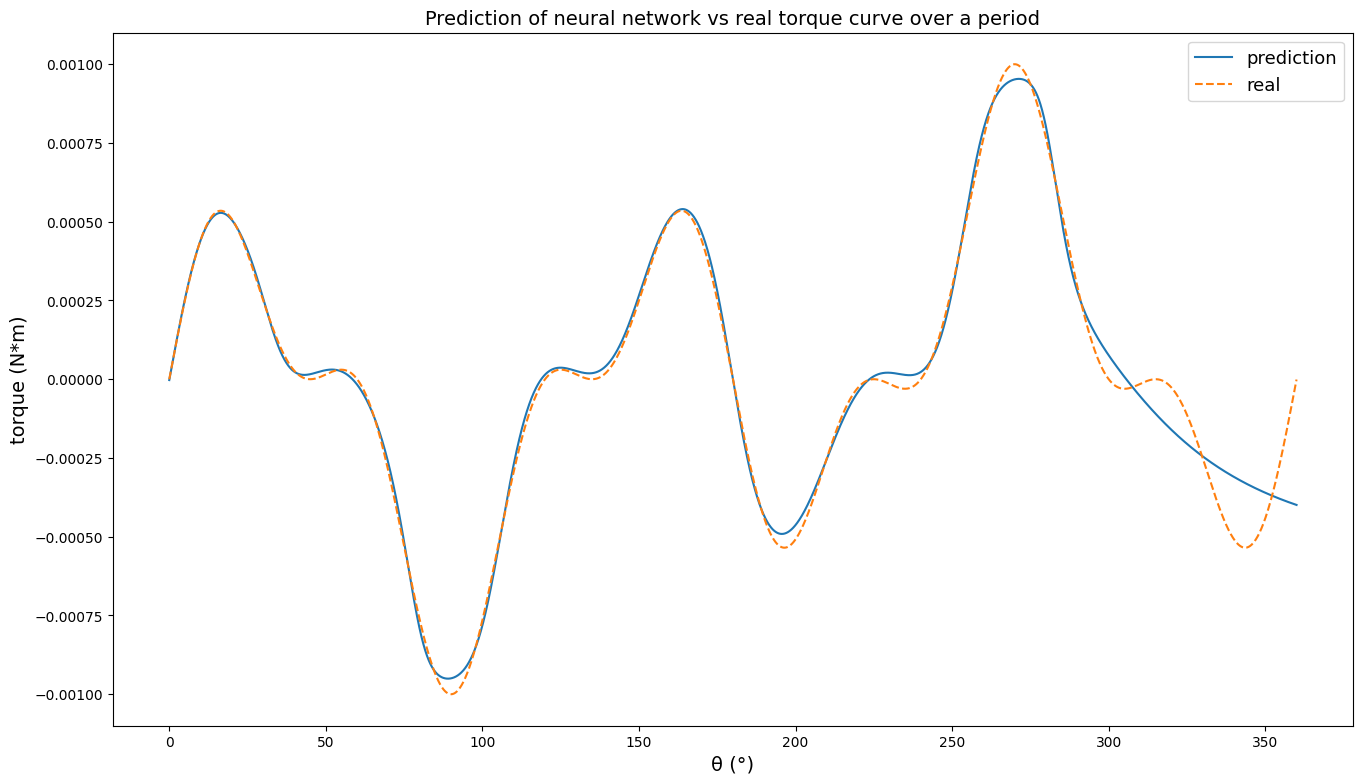

In [18]:
# visualizing the error after each epoch
cut = int(epoch*0.1)
fig, ax = plt.subplots(1, 2, figsize=(14,3))
fig.suptitle("Error on training data after each epoch")
ax[0].plot(np.arange(0, cut+1), np.array(losses[:cut+1]))
ax[0].set_ylabel('epochs 0 to %i' %cut)
ax[1].plot(np.arange(cut+1, epoch), np.array(losses[cut+1:]))
ax[1].set_ylabel('epochs '+str(cut+1)+' to '+str(epoch-1))
plt.show()

y_predicted = np.squeeze(model(torch.from_numpy(X[:,None])).detach().numpy())
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(180/np.pi*n, 1e-3*y_predicted, label='prediction')
plt.plot(180/np.pi*n, 1e-3*func, '--', label='real')
plt.legend(fontsize=13)
plt.title("Prediction of neural network vs real torque curve over a period",fontsize=14)
ax.set_xlabel("θ (°)",fontsize=14)
ax.set_ylabel("torque (N*m)",fontsize=14)
plt.show()

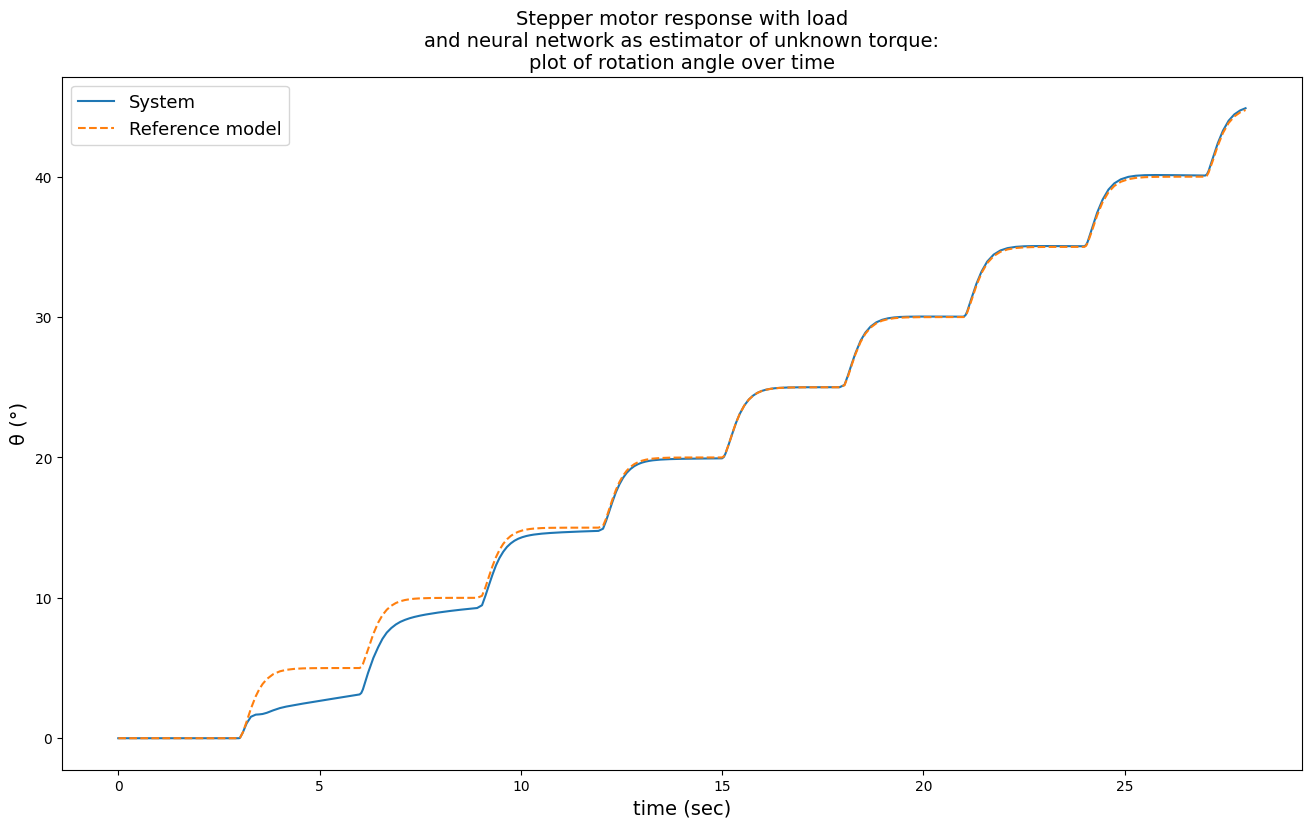

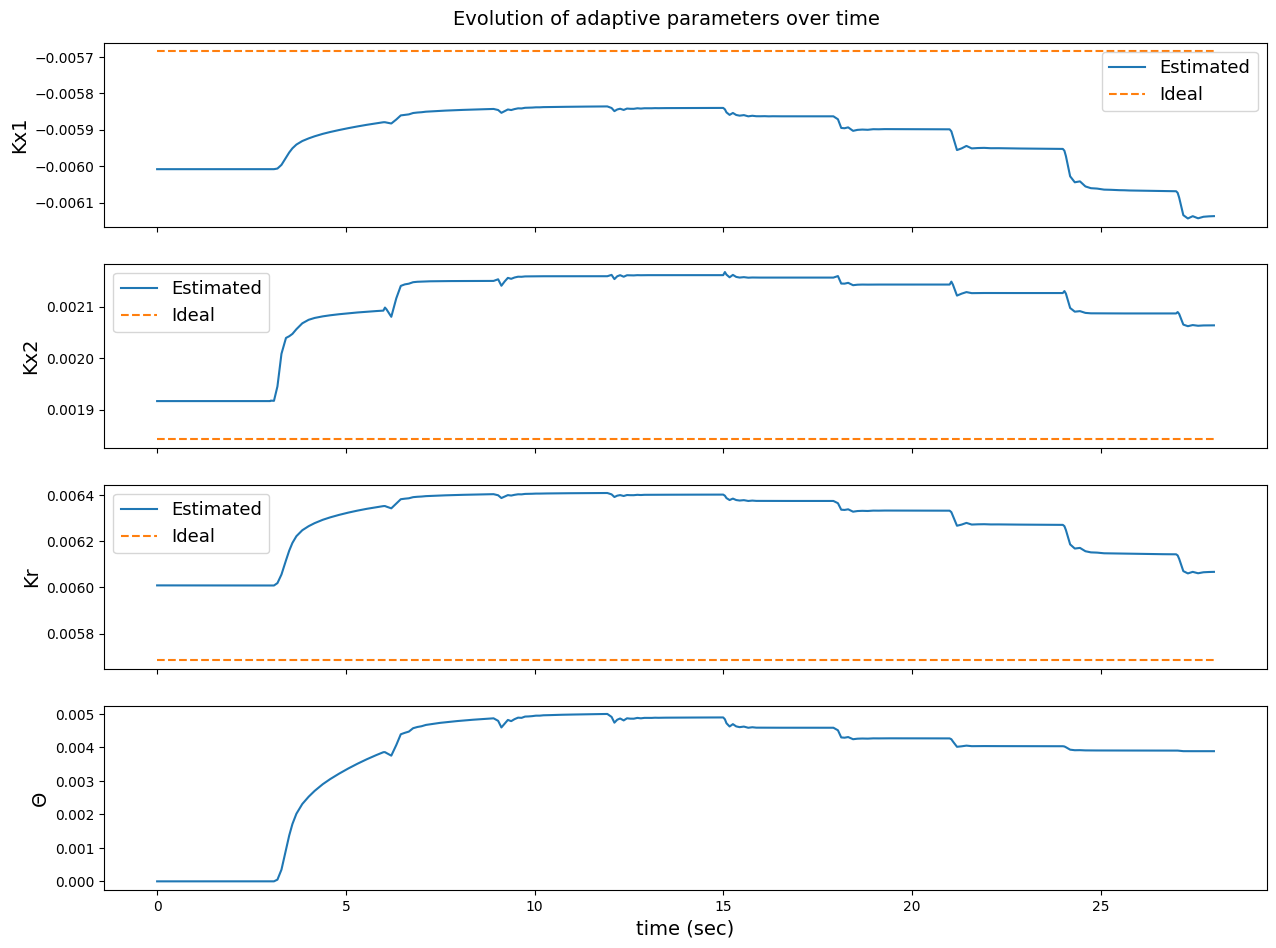

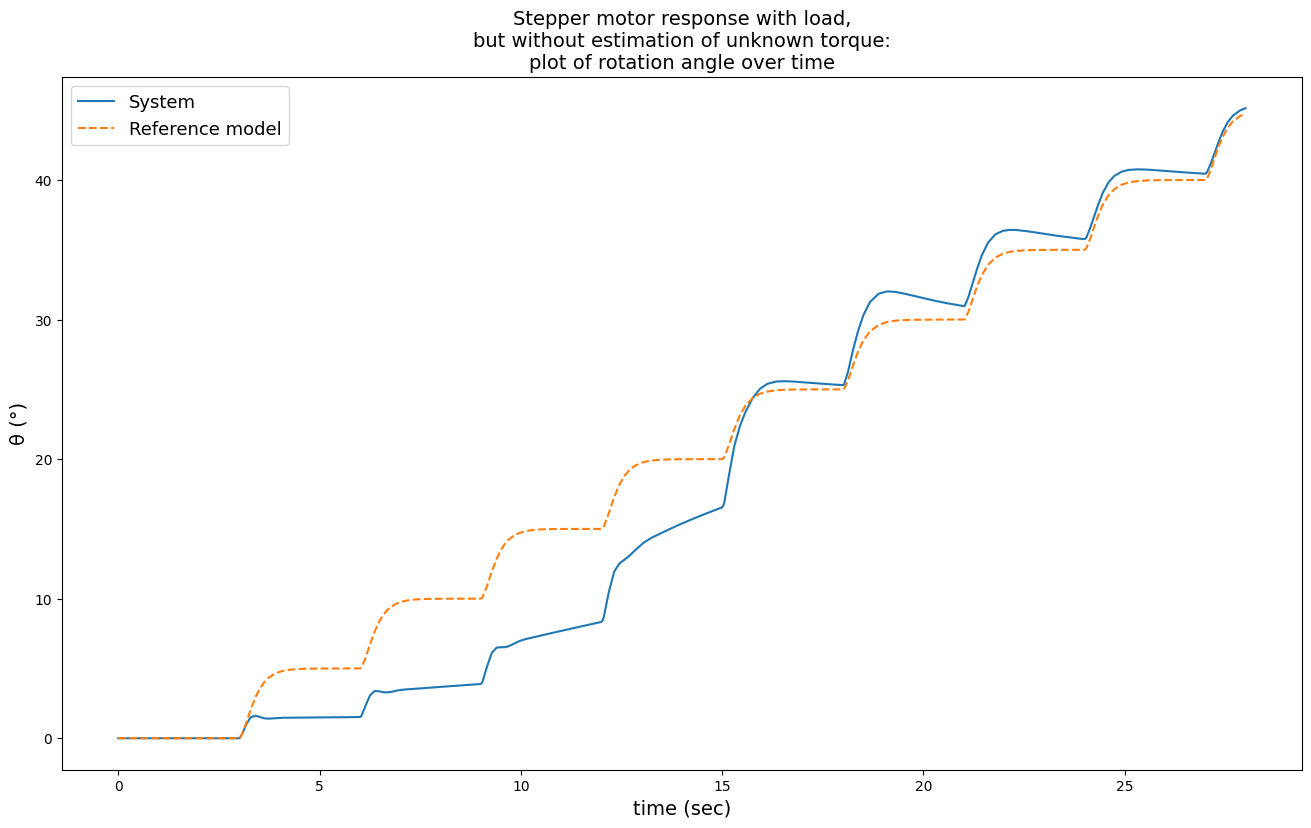

In [19]:
# Run the simulation for the response of the motor to the applied torque approximated by the neural network

solution = simulate_system(t_span=28,ext_torque=True,nn_torque_model=model)
plot_response(solution, 0, string=
              " with load\nand neural network as estimator of unknown torque")

plot_parameters(solution,nonlinear=True)

solution = simulate_system(t_span=28,ext_torque=True)
plot_response(solution, 0, string=
              " with load,\nbut without estimation of unknown torque")